In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import io
# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"
import os

PROJECT_ID = ""

if not os.getenv("IS_TESTING"):
    # Get your Google Cloud project ID from gcloud
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "bigbucket"  # @param {type:"string"}
from datetime import datetime
from google.colab import auth
auth.authenticate_user()
!echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!sudo apt-get -y -q update
!sudo apt-get -y -q install gcsfuse
from google.colab import auth
auth.authenticate_user()
!mkdir -p medium
bucket_name='medium_mush'
!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 {bucket_name} medium

Project ID:  
deb http://packages.cloud.google.com/apt gcsfuse-bionic main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0    99k      0 --:--:-- --:--:-- --:--:--   99k
OK
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 htt

In [ ]:
import PIL
import pandas as pd
import pathlib

data_dir = pathlib.Path('/content/gcs/inat/train/')

In [65]:
batch_size = 8
img_height = 180
img_width = 180

In [66]:
print(f"o: {len(os.listdir('/content/gcs/inat/train/o/'))}, m: {len(os.listdir('/content/gcs/inat/train/m/'))}, g: {len(os.listdir('/content/gcs/inat/train/g/'))}")

o: 1321, m: 697, g: 311


In [67]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2329 files belonging to 3 classes.
Using 1864 files for training.


In [68]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2329 files belonging to 3 classes.
Using 465 files for validation.


In [69]:
class_names = train_ds.class_names
print(class_names)

['g', 'm', 'o']


InvalidArgumentError: ignored

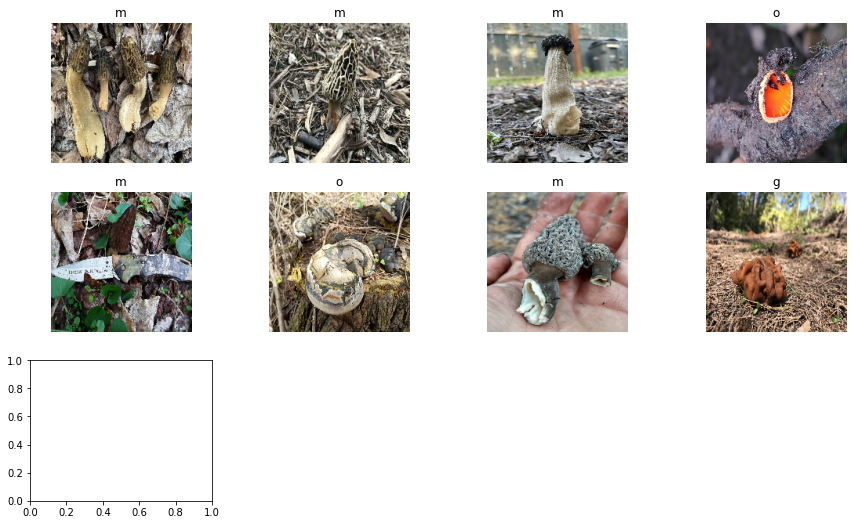

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
def normalize(ds):
    normalization = tf.keras.layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization(x), y))
    return ds

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTO)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [46]:
# AUTO = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTO)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTO)

In [71]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),                             
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(3)
])

In [72]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [73]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
233/233 [==============================] - 97s 404ms/step - loss: 0.9450 - accuracy: 0.5617 - val_loss: 0.8363 - val_accuracy: 0.5978
Epoch 2/3
233/233 [==============================] - 147s 613ms/step - loss: 0.8611 - accuracy: 0.5783 - val_loss: 0.8091 - val_accuracy: 0.6344
Epoch 3/3
233/233 [==============================] - 147s 611ms/step - loss: 0.8088 - accuracy: 0.6229 - val_loss: 0.7967 - val_accuracy: 0.6151


In [81]:
WIDTH = 300
HEIGHT = 300
BATCH_SIZE = 64

In [98]:
path = pathlib.Path('/content/medium/mush/')
train_ds = tf.keras.utils.image_dataset_from_directory(path, subset='training', seed=111, validation_split=0.15, image_size=(WIDTH, HEIGHT), batch_size=BATCH_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(path, subset='validation', seed=111, validation_split=0.15, image_size=(WIDTH, HEIGHT), batch_size=BATCH_SIZE)

Found 12143 files belonging to 3 classes.
Using 10322 files for training.
Found 12143 files belonging to 3 classes.
Using 1821 files for validation.


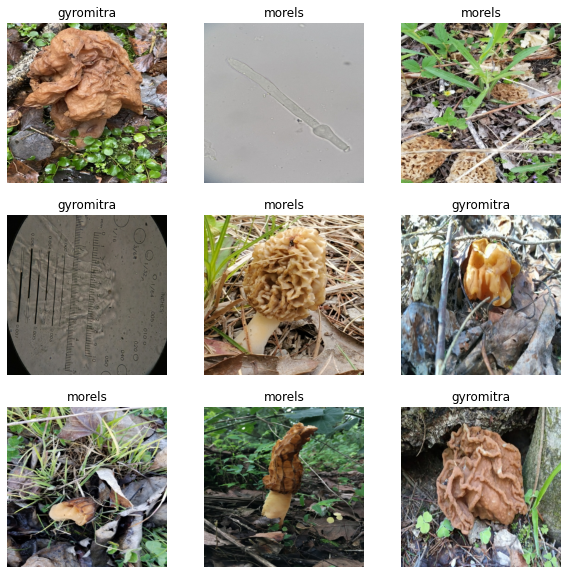

In [99]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [100]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 300, 300, 3)
(64,)


In [101]:
import seaborn as sns
labels = []
for x, y in train_ds:
  # Not one hot encoded
  labels.append(y.numpy())

  # If one hot encoded, then apply argmax
  # labels.append(np.argmax(y, axis = -1))
labels = np.concatenate(labels, axis = 0) # Assuming dataset was batched.

InvalidArgumentError: ignored

In [93]:
from struct import unpack
import os.path as osp
import tqdm


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
               raise TypeError("issue reading jpeg file")          


bads = []
# img_dir= '/content/medium/mush/other/'
# for dirName, subdirList, fileList in os.walk(img_dir):
#     imagesList = fileList
#     for img in tqdm.tqdm(imagesList):
#         image = osp.join(img_dir,img)
#         image = JPEG(image) 
#         try:
#           image.decode()   
#         except:
#           bads.append(img)

# img_dir= '/content/medium/mush/morels/'
# for dirName, subdirList, fileList in os.walk(img_dir):
#     imagesList = fileList
#     for img in tqdm.tqdm(imagesList):
#         image = osp.join(img_dir,img)
#         image = JPEG(image) 
#         try:
#           image.decode()   
#         except:
#           bads.append(img)

img_dir= '/content/medium/mush/gyromitra/'
for dirName, subdirList, fileList in os.walk(img_dir):
    imagesList = fileList
    for img in tqdm.tqdm(imagesList):
        image = osp.join(img_dir,img)
        image = JPEG(image) 
        try:
          image.decode()   
        except:
          bads.append(img)

for name in bads:
  os.remove(osp.join(img_dir,name))

100%|██████████| 7268/7268 [10:15<00:00, 11.81it/s]


In [94]:
img_dir= '/content/medium/mush/gyromitra/'
for dirName, subdirList, fileList in os.walk(img_dir):
    imagesList = fileList
    for img in tqdm.tqdm(imagesList):
        image = osp.join(img_dir,img)
        image = JPEG(image) 
        try:
          image.decode()   
        except:
          bads.append(img)

100%|██████████| 3996/3996 [05:15<00:00, 12.68it/s]
